In [62]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


In [ ]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features # Preditores
Y = wine_quality.data.targets # Output

# metadata
print(wine_quality.metadata)

print(wine_quality.variables)

In [19]:
df_white = pd.read_csv("../dataset/winequality-white.csv", sep=';',index_col=False)
df_white['type'] = 1
df_red = pd.read_csv("../dataset/winequality-red.csv", sep=';',index_col=False)
df_wine = pd.concat([df_red, df_white], ignore_index=True)
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,NaN
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,NaN
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,NaN
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,NaN
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1.0


In [50]:
X = df_wine.drop("quality", axis=1)
X = X.drop("type", axis=1)
y = df_wine["quality"]


In [51]:
# shuffle indexes
idx = np.arange(len(df_wine))
np.random.seed(42)
np.random.shuffle(idx)

# 80% train, 20% test
split_point = int(0.8 * len(df_wine))

train_idx = idx[:split_point]
test_idx  = idx[split_point:]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


In [52]:
X_train_scaled = (X_train - X_train.mean()) / X_train.std()
X_test_scaled = (X_test - X_train.mean()) / X_train.std()


In [53]:
# Create OLS model
X_train_adjusted = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])

beta = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train

# Apply OLS model on the test data
X_test_adjusted = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

y_predicted = X_test_adjusted @ beta
y_predicted

array([5.95776076, 6.76894763, 5.21481896, ..., 5.39861209, 5.49946142,
       5.05678175], shape=(1300,))

In [79]:
# RMSE Calculation
rmse = np.sum((y_test - y_predicted)**2)
rmse = np.sqrt(rmse/len(y_predicted))

# R2 Calculation
r2 = np.sum((y_test - y_predicted)**2)
r2 = r2/np.sum((y_test - y_test.mean())**2)
r2 = 1 - r2

print("RMSE =", rmse)
print("R2 =", r2)

RMSE = 0.7379489530808737
R2 = 0.2837322038979112


In [ ]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled, y_train)

y_prediction_builtin = lr.predict(X_test_scaled)
y_prediction_builtin

array([5.95776076, 6.76894763, 5.21481896, ..., 5.39861209, 5.49946142,
       5.05678175], shape=(1300,))

In [80]:
# RMSE Calculation for built-in code
rmse_builtin = np.sum((y_test - y_prediction_builtin)**2)
rmse_builtin = np.sqrt(rmse_builtin/len(y_prediction_builtin))

# R2 Calculation for built-in code
r2_builtin = np.sum((y_test - y_prediction_builtin)**2)
r2_builtin = r2_builtin/np.sum((y_test - y_test.mean())**2)
r2_builtin = 1 - r2_builtin

print("Built-in RMSE =", rmse_builtin)
print("Built-inR2 =", r2_builtin)

Built-in RMSE = 0.7379489530808738
Built-inR2 = 0.2837322038979111


In [68]:
def k_fold(X, y, k):
    np.random.seed(42)
    
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    new_X = X[indices]
    new_y = y[indices]

    fold_size = len(X) // k
    folds_X = []
    folds_y = []
    rmse_list = []
    r2_list = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds_X.append(new_X[start:end])
        folds_y.append(new_y[start:end])

    for i in range(k):
        X_val = folds_X[i]
        y_val = folds_y[i]

        X_train_fold = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train_fold = np.hstack([folds_y[j] for j in range(k) if j != i])

        X_train_fold_scaled = (X_train_fold - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)
        X_val_scaled        = (X_val - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)

        X_train_fold_adjusted = np.hstack([np.ones((X_train_fold_scaled.shape[0], 1)), X_train_fold_scaled])

        beta_i = np.linalg.inv(X_train_fold_adjusted.T @ X_train_fold_adjusted) @ X_train_fold_adjusted.T @ y_train_fold

        X_val_adj = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])

        y_pred_val = X_val_adj @ beta_i
        # RMSE calculation
        rmse_fold = np.sum((y_val - y_pred_val)**2)
        rmse_fold = np.sqrt(rmse_fold/len(y_pred_val))
        # R2 calculation
        r2_fold = np.sum((y_val - y_pred_val)**2)
        r2_fold = r2_fold/np.sum((y_val - y_val.mean())**2)
        r2_fold = 1 - r2_fold

        rmse_list.append(rmse_fold)
        r2_list.append(r2_fold)
    return rmse_list, r2_list, np.mean(rmse_list), np.std(rmse_list), np.mean(r2_list), np.std(r2_list)


In [71]:
def print_builtin_results(name, rmse_scores, r2_scores):
    print(f"\n====== {name} (BUILT-IN) ======")
    print(f"RMSE per fold: {['{:.4f}'.format(x) for x in rmse_scores]}")
    print(f"R² per fold  : {['{:.4f}'.format(x) for x in r2_scores]}")
    print(f"\nRMSE Mean ± Std: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"R²   Mean ± Std: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("=========================\n")

def print_cv_results(name, results):
    print(f"\n====== {name} ======")
    print(f"RMSE per fold: {['{:.4f}'.format(x) for x in results[0]]}")
    print(f"R² per fold  : {['{:.4f}'.format(x) for x in results[1]]}")
    print(f"\nRMSE Mean ± Std: {results[2]:.4f} ± {results[3]:.4f}")
    print(f"R²   Mean ± Std: {results[4]:.4f} ± {results[5]:.4f}")
    print("=========================\n")



In [78]:
k_fold_results_5 = k_fold(X_train_scaled, y_train.to_numpy(), k=5)
k_fold_results_10 = k_fold(X_train_scaled, y_train.to_numpy(), k=10)

print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)



====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7604', '0.7424', '0.7255', '0.7434', '0.7092']
R² per fold  : ['0.2600', '0.2980', '0.3054', '0.2588', '0.3249']

RMSE Mean ± Std: 0.7362 ± 0.0174
R²   Mean ± Std: 0.2894 ± 0.0260


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7876', '0.7322', '0.7684', '0.7144', '0.7265', '0.7212', '0.7656', '0.7262', '0.6877', '0.7228']
R² per fold  : ['0.1831', '0.3328', '0.2846', '0.3133', '0.3068', '0.3056', '0.2254', '0.2843', '0.3502', '0.3064']

RMSE Mean ± Std: 0.7353 ± 0.0282
R²   Mean ± Std: 0.2892 ± 0.0474



In [75]:
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_5 = np.sqrt(-cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=kf5, scoring="neg_mean_squared_error"))
r2_scores_5 = cross_val_score(lr, X_train_scaled, y_train, cv=kf5, scoring="r2")


kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores_10 = np.sqrt(-cross_val_score(lr, X_train_scaled, y_train, cv=kf10, scoring="neg_mean_squared_error"))
r2_scores_10 = cross_val_score(lr, X_train_scaled, y_train, cv=kf10, scoring="r2")

print_builtin_results("5-FOLD CROSS VALIDATION", rmse_scores_5, r2_scores_5)
print_builtin_results("10-FOLD CROSS VALIDATION", rmse_scores_10, r2_scores_10)



====== 5-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.7601', '0.7426', '0.7252', '0.7433', '0.7091']
R² per fold  : ['0.2605', '0.2970', '0.3055', '0.2615', '0.3229']

RMSE Mean ± Std: 0.7360 ± 0.0174
R²   Mean ± Std: 0.2895 ± 0.0247


====== 10-FOLD CROSS VALIDATION (BUILT-IN) ======
RMSE per fold: ['0.7869', '0.7315', '0.7674', '0.7177', '0.7270', '0.7211', '0.7635', '0.7237', '0.6892', '0.7280']
R² per fold  : ['0.1831', '0.3339', '0.2838', '0.3067', '0.3101', '0.3036', '0.2363', '0.2867', '0.3477', '0.2985']

RMSE Mean ± Std: 0.7356 ± 0.0272
R²   Mean ± Std: 0.2890 ± 0.0453



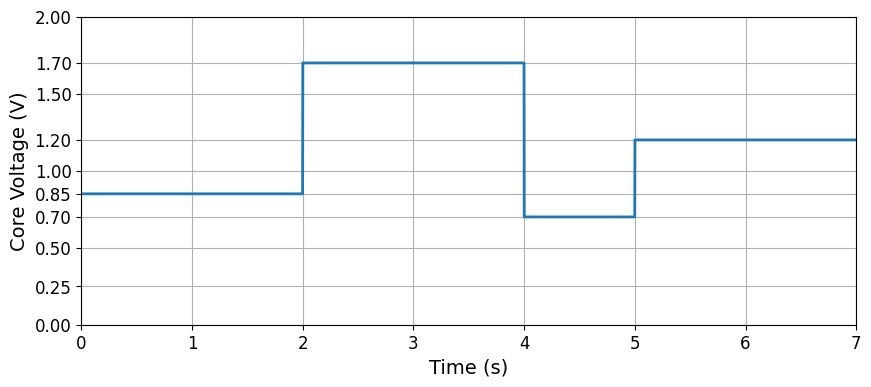

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# tempos de cada etapa (em segundos)
t1 = 2    # tempo até o primeiro degrau
t2 = 4    # tempo até o segundo degrau
t3 = 5    # tempo até o terceiro degrau
t_final = 7

# resolução temporal
dt = 0.001
t = np.arange(0, t_final, dt)

# vetor de tensão
v = np.zeros_like(t)

# valores de tensão em cada etapa
v1 = 0.85
v2 = 1.7
v3 = 0.7
v4 = 1.2   # valor intermediário

# construção dos degraus
v[t < t1] = v1
v[(t >= t1) & (t < t2)] = v2
v[(t >= t2) & (t < t3)] = v3
v[t >= t3] = v4

# plot
plt.figure(figsize=(10,4))
plt.plot(t, v, linewidth=2)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Core Voltage (V)", fontsize=14)
plt.grid(True)

# limite do eixo Y
plt.ylim(0, 2)
plt.xlim(0, 7)

# ticks padrão
default_ticks = plt.gca().get_yticks()

# valores extras dos degraus
extra_ticks = [v1, v2, v3, v4]

# combinar ticks
all_ticks = sorted(set(default_ticks) | set(extra_ticks))

# ticks a remover
remove_ticks = {0.75, 1.25, 1.75}

# remover ticks indesejados
filtered_ticks = [tick for tick in all_ticks if tick not in remove_ticks]
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.yticks(filtered_ticks)

plt.show()


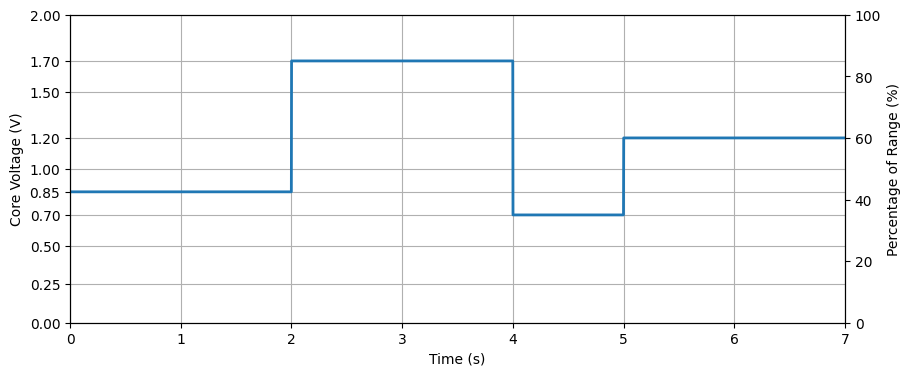

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# tempos de cada etapa (em segundos)
t1 = 2
t2 = 4
t3 = 5
t_final = 7

# resolução temporal
dt = 0.001
t = np.arange(0, t_final, dt)

# valores dos degraus
v1 = 0.85
v2 = 1.7
v3 = 0.7
v4 = 1.2

# vetor de tensão
v = np.zeros_like(t)
v[t < t1] = v1
v[(t >= t1) & (t < t2)] = v2
v[(t >= t2) & (t < t3)] = v3
v[t >= t3] = v4

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(t, v, linewidth=2)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Core Voltage (V)")
ax.grid(True)
ax.set_ylim(0, 2)
ax.set_xlim(0, 7)

# ----- EIXO SECUNDÁRIO EM PORCENTAGEM -----
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel("Percentage of Range (%)")

# manter ticks originais + degraus
default_ticks = ax.get_yticks()
extra_ticks = [v1, v2, v3, v4]
all_ticks = sorted(set(default_ticks) | set(extra_ticks))
remove_ticks = {0.75, 1.25, 1.75}
filtered_ticks = [tick for tick in all_ticks if tick not in remove_ticks]

ax.set_yticks(filtered_ticks)

plt.show()
